In [ ]:
!pip install wandb
!pip install swig
!pip install gym[all]
!pip install pygame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 12.3 MB/s eta 0:00

Episode 1: Total Reward: -170.08 Timesteps: 104
Episode 2: Total Reward: -375.36 Timesteps: 108
Episode 3: Total Reward: -414.00 Timesteps: 112
Episode 4: Total Reward: -73.09 Timesteps: 85
Episode 5: Total Reward: -237.82 Timesteps: 94
Episode 6: Total Reward: -349.05 Timesteps: 108
Episode 7: Total Reward: -103.85 Timesteps: 61
Episode 8: Total Reward: -72.55 Timesteps: 73
Episode 9: Total Reward: -232.77 Timesteps: 92
Episode 10: Total Reward: -178.05 Timesteps: 116
Episode 11: Total Reward: -155.13 Timesteps: 72
Episode 12: Total Reward: -121.65 Timesteps: 72
Episode 13: Total Reward: -132.97 Timesteps: 81
Episode 14: Total Reward: -137.13 Timesteps: 68
Episode 15: Total Reward: -290.00 Timesteps: 84
Episode 16: Total Reward: -92.40 Timesteps: 130
Episode 17: Total Reward: -125.63 Timesteps: 76
Episode 18: Total Reward: -142.41 Timesteps: 94
Episode 19: Total Reward: -109.58 Timesteps: 85
Episode 20: Total Reward: -205.29 Timesteps: 52
Episode 21: Total Reward: -164.12 Timesteps: 8

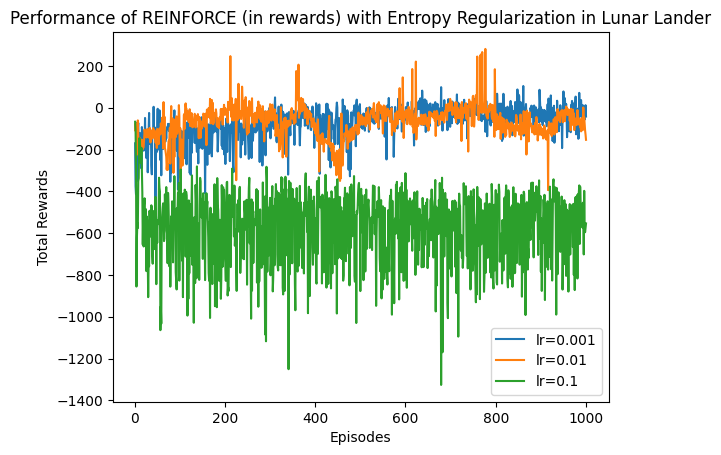

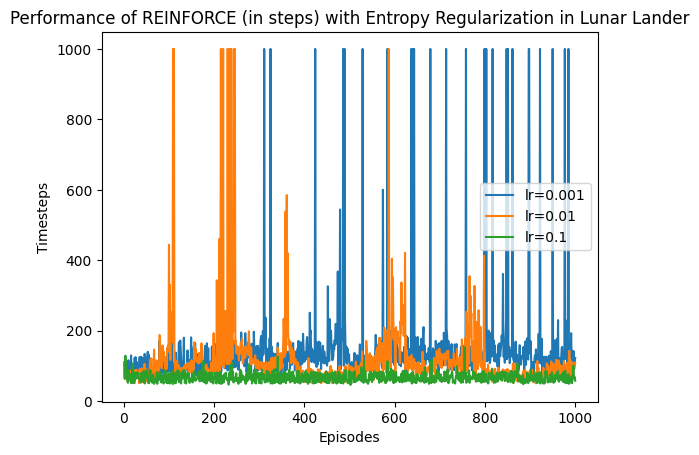

In [ ]:
import gym
import numpy as np
import torch
import random
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Define a simple policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gamma=0.99, lr=0.001):
        super(PolicyNetwork, self).__init__()
        self.lr = lr
        self.gamma = gamma
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return torch.softmax(x, dim=-1)

# Function to collect trajectories
def collect_trajectories(policy_network, env):
    trajectories = []
    total_reward = 0
    timesteps = 0
    episode = {'states': [], 'actions': [], 'rewards': []}
    state = env.reset()
    done = False
    while not done:
        timesteps += 1
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = policy_network(state)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()
        next_state, reward, done, _ = env.step(action.item())
        total_reward += reward
        episode['states'].append(state)
        episode['actions'].append(action)
        episode['rewards'].append(reward)
        state = next_state

    trajectories.append(episode)
    return trajectories, total_reward, timesteps

# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    running_add = 0
    for r in reversed(rewards):
        running_add = running_add * gamma + r
        discounted_rewards.insert(0, running_add)
    return discounted_rewards

# Function to update the policy network with entropy regularization
def update_with_entropy_regularization(policy_network, trajectories, gamma, entropy_weight):
    for episode in trajectories:
        loss = 0
        entropy = 0
        discounted_rewards = compute_discounted_rewards(episode['rewards'], gamma)
        baseline = np.mean(discounted_rewards)
        for state, action, dr in zip(episode['states'], episode['actions'], discounted_rewards):
            action_probs = policy_network(state)
            action_dist = Categorical(action_probs)
            log_prob = action_dist.log_prob(action)
            entropy += action_dist.entropy()
            advantage = dr - baseline
            loss -= (log_prob * advantage) + (entropy_weight * entropy)

        policy_network.optimizer.zero_grad()
        loss.backward()
        policy_network.optimizer.step()

# Main function for training
def train():
    # Set up environment
    random.seed(350)
    env = gym.make('LunarLander-v2')
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    hidden_dim = 256

    # Hyperparameters
    n_episodes = 1000
    gamma = 0.99
    entropy_weight = 0.01  # Adjust this parameter to control the strength of entropy regularization

    policy_network = PolicyNetwork(input_dim, hidden_dim, output_dim, lr=0.001)
    rewards_array = []
    timesteps_array = []

    # Training loop
    for episode in range(n_episodes):
        trajectories, rewards, timesteps = collect_trajectories(policy_network, env)
        update_with_entropy_regularization(policy_network, trajectories, gamma, entropy_weight)
        rewards_array.append(rewards)
        timesteps_array.append(timesteps)
        print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))

    policy_network_2 = PolicyNetwork(input_dim, hidden_dim, output_dim, lr=0.01)
    rewards_array2 = []
    timesteps_array2 = []

    # Training loop
    for episode in range(n_episodes):
        trajectories, rewards, timesteps = collect_trajectories(policy_network_2, env)
        update_with_entropy_regularization(policy_network_2, trajectories, gamma, entropy_weight)
        rewards_array2.append(rewards)
        timesteps_array2.append(timesteps)
        print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))

    policy_network_3 = PolicyNetwork(input_dim, hidden_dim, output_dim, lr=0.1)
    rewards_array3 = []
    timesteps_array3 = []

    # Training loop
    for episode in range(n_episodes):
        trajectories, rewards, timesteps = collect_trajectories(policy_network_3, env)
        update_with_entropy_regularization(policy_network_3, trajectories, gamma, entropy_weight)
        rewards_array3.append(rewards)
        timesteps_array3.append(timesteps)
        print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))



    # Plotting
    plt.title("Performance of REINFORCE (in rewards) with Entropy Regularization in Lunar Lander")
    plt.plot(range(1, n_episodes + 1), rewards_array, label="lr=0.001")
    plt.plot(range(1, n_episodes + 1), rewards_array2, label="lr=0.01")
    plt.plot(range(1, n_episodes + 1), rewards_array3, label="lr=0.1")
    plt.xlabel("Episodes")
    plt.ylabel("Total Rewards")
    plt.legend()
    plt.show()

    plt.title("Performance of REINFORCE (in steps) with Entropy Regularization in Lunar Lander")
    plt.plot(range(1, n_episodes + 1), timesteps_array, label="lr=0.001")
    plt.plot(range(1, n_episodes + 1), timesteps_array2, label="lr=0.01")
    plt.plot(range(1, n_episodes + 1), timesteps_array3, label="lr=0.1")
    plt.xlabel("Episodes")
    plt.ylabel("Timesteps")
    plt.legend()
    plt.show()

    env.close()

# Run the training
train()
